# Seminar 1. Bandit algorithms

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

During this course we will use `rlberry` library that contains a lot of helpful things for RL that will allow us focus only on algorithms, not on logging and wrapping environments. Documentation: https://rlberry.readthedocs.io/en/latest/index.html

In [ ]:
!pip -q install git+https://github.com/rlberry-py/rlberry.git@v0.3.0#egg=rlberry[default]

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 21.8 MB 1.6 MB/s 
     |████████████████████████████████| 348 kB 51.4 MB/s 
     |████████████████████████████████| 538 kB 54.3 MB/s 
     |████████████████████████████████| 209 kB 57.8 MB/s 
     |████████████████████████████████| 81 kB 9.2 MB/s 
     |████████████████████████████████| 78 kB 7.9 MB/s 
     |████████████████████████████████| 112 kB 52.9 MB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 
     |████████████████████████████████| 147 kB 72.4 MB/s 


Base class `BanditWithSimplePolicy` for all our bandit algorithms, for which funcion `fit` has to be redefined. There is also `IndexAgent` base class that will be also suitable for our algorithms, but we focus on more low-lever interface.


In [ ]:
from rlberry.agents.bandits import BanditWithSimplePolicy
from rlberry.wrappers import WriterWrapper

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


First, we implement the simplest agent that acts greedy with respect to mean estimates for arms.

In [ ]:
class GreedyAgent(BanditWithSimplePolicy):
    """
        Simple greedy agent.

        Parameters:
        -----------
        env: rlberry bandit environment

    """
    name = "Greedy"

    def __init__(self, env, eps, **kwargs):
        """
            Usefull fields of base class:
            * self.n_arms : number of arms
        """
        BanditWithSimplePolicy.__init__(self, env, **kwargs)
        # To track statistics on chosen actions
        self.env = WriterWrapper(self.env, self.writer, write_scalar="action")
        self.eps = eps

    def fit(self, budget=None, **kwargs):
        """
        Fit function for greedy agent
        Parameters
        ----------
        budget: int
            Total number of iterations, also called horizon.
        """
        horizon = budget
        rewards = np.zeros(horizon)

        mu_hats = np.zeros(self.n_arms)  + np.inf
        pull_rewards = np.zeros(self.n_arms)
        n_pulls = np.zeros(self.n_arms)

        for ep in range(horizon):
            # choose the optimal action
            if np.random.uniform() < self.eps:
                action = np.random.choice(np.arange(self.n_arms))
            else:
                action = np.argmax(mu_hats)
            _, reward, _, _ = self.env.step(action)

            # update statistics
            n_pulls[action] += 1
            pull_rewards[action] += reward
            mu_hats[action] = pull_rewards[action] / n_pulls[action]

            rewards[ep] = reward

        self.optimal_action = np.argmax(mu_hats)
        info = {"episode_reward": np.sum(rewards)}
        return info


In [ ]:
class ExploreFirstAgent(BanditWithSimplePolicy):
    """
        Explore-First algorithm

        Parameters:
        -----------
        env: rlberry bandit environment
        N: int
            number of steps used to explore one arm
    """
    name = "ExploreFirst"


    def __init__(self, env, N, **kwargs):
        BanditWithSimplePolicy.__init__(self, env, **kwargs)
        self.env = WriterWrapper(self.env, self.writer, write_scalar="action")
        # Define the arm estimation budget
        self.N = N

    def fit(self, budget=None, **kwargs):
        """
        Fit function for Explore-First agent
        Parameters
        ----------
        budget: int
            Total number of iterations, also called horizon.
        """
        # Check that learning budget is great than number of exploration steps
        if budget < self.n_arms * self.N:
            raise ValueError('Exploration phase is too long')

        horizon = budget
        rewards = np.zeros(horizon)
        pull_rewards = np.zeros(self.n_arms)
        it = 0

        for action in range(self.n_arms):
            for ep in range(self.N):
                _, reward, _, _ = self.env.step(action)
                pull_rewards[action] += reward
                rewards[it] = reward
                it += 1

        # Compute optimal arm with respect to sampled actions
        self.optimal_action = np.argmax([pull_rewards / self.N for a in range(self.n_arms)])

        for ep in range(self.n_arms * self.N, horizon):
            # choose the optimal action
            action = self.optimal_action
            _, reward, _, _ = self.env.step(action)

            rewards[ep] = reward

        info = {"episode_reward": np.sum(rewards)}
        return info


Next we are going to compare these agents on simple envrionment using `rlberry`.

In [ ]:
from rlberry.envs.bandits import BernoulliBandit
env_ctor = BernoulliBandit
p = np.array([0.3, 0.4, 0.3, 0.2, 0.45])  # optimal arm is the last one
env_kwargs = {"p" : p}

In [ ]:
T = 2500     # budget
M = 10       # number of seeds to repeat
eps = 0.5
N = 200     # number of estimation steps for ExploreFirst algorithm

In [ ]:
from rlberry.manager import AgentManager, plot_writer_data

greedy_agent = AgentManager(
        GreedyAgent,
        (env_ctor, env_kwargs),
        init_kwargs={"eps": eps},
        fit_budget=T,
        n_fit=M,
        parallelization="process",      # To make parallel evaluation for different seeds
        mp_context="fork"
)

explore_first_agent = AgentManager(
        ExploreFirstAgent,
        (env_ctor, env_kwargs),
        init_kwargs={"N": N},
        fit_budget=T,
        n_fit=M,
        parallelization="process",      # To make parallel evaluation for different seeds
        mp_context="fork"
)

agents = [greedy_agent, explore_first_agent]


In [ ]:
for agent in agents:
    agent.fit()

[INFO] Running AgentManager fit() for Greedy with n_fit = 10 and max_workers = None. 
/usr/local/lib/python3.7/dist-packages/gym/core.py:257: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
/usr/local/lib/python3.7/dist-packages/gym/core.py:257: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
[INFO] ... trained! 
/usr/local/lib/python3.7/dist-packages/gym/core.py:257: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the fut

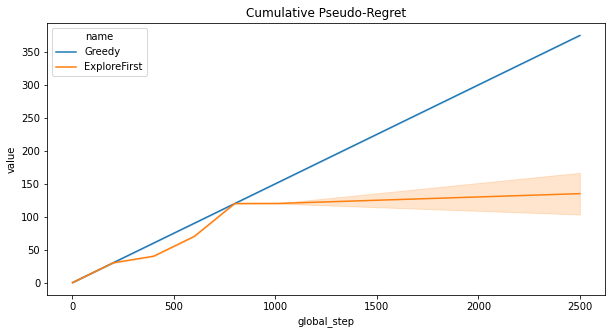

In [ ]:
# Compute and plot regret
def compute_pseudo_regret(actions):
    return np.cumsum(np.max(p) - p[actions.astype(int)])


fig = plt.figure(1, figsize=(10, 5))
ax = plt.gca()
output = plot_writer_data(
    agents,
    tag="action",
    preprocess_func=compute_pseudo_regret,
    title="Cumulative Pseudo-Regret",
    ax=ax,
)

Questions:
* Can we improve performance of greedy algorithm by using of **another initialization**?
* What the effect of parameter $N$ on regret curve for Explore-First algorithm? What is the optimal one from theoretical and practical point of view?
* What the effect of parameter ɛ on regret curve for ɛ-greedy strategy? What is the proper initailization for it?